In [1]:
!pip install -q mediapipe==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 16.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Import**

In [4]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import random
import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from  keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import  ResNet50
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import mediapipe as mp
import cv2
from keras.utils import to_categorical
from PIL import Image

# **folder split and data selection**

In [5]:
filtered_data_df = pd.read_csv('/content/drive/MyDrive/palmar/Palmar_Hand_Info.csv')
def transform_id_column(df):
    unique_ids = df['id'].unique()
    id_mapping = {id_val: i for i, id_val in enumerate(unique_ids)}
    df['id'] = df['id'].map(id_mapping)
    return df
df = transform_id_column(filtered_data_df)

In [ ]:
# Create a directory to store the folders
output_dir = '/content/drive/MyDrive/palmar/data_folder'

os.makedirs(output_dir, exist_ok=True)

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    image_name = row['image_name']
    folder_name = str(row['id'])

    # Create a folder for each ID if it doesn't exist
    folder_path = os.path.join(output_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    # Copy the image to the corresponding folder
    source_path = os.path.join('/content/drive/MyDrive/palmar/palmar_original', image_name)
    destination_path = os.path.join(folder_path, image_name)
    shutil.copyfile(source_path, destination_path)

print('Images have been organized into folders.')

In [ ]:
folder_path = '/content/drive/MyDrive/palmar/data_folder'

# List to store subfolders with more than 50 images
subfolders_with_more_than_50_images = []

# Iterate over subfolders
for subfolder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder_name)
    if os.path.isdir(subfolder_path):
        image_count = 0
        # Iterate over files in the subfolder
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            # Check if the file is an image
            try:
                image = Image.open(file_path)
                image_count += 1
            except (IOError, OSError):
                # File is not an image
                pass
        if image_count > 50:
            subfolders_with_more_than_50_images.append(subfolder_name)

print("Subfolders with more than 50 images:")
print(subfolders_with_more_than_50_images)

Subfolders with more than 50 images:
['63', '64', '70', '74', '82', '84', '89', '91', '92', '120', '125', '143']


In [ ]:
destination_folder = '/content/drive/MyDrive/palmar/data_more_50'

# Copy subfolders to the destination folder
for subfolder_name in subfolders_with_more_than_50_images:
    source_subfolder_path = os.path.join(folder_path, subfolder_name)
    destination_subfolder_path = os.path.join(destination_folder, subfolder_name)
    shutil.copytree(source_subfolder_path, destination_subfolder_path)

print("Subfolders copied successfully.")

Subfolders copied successfully.


# **Classes**

In [6]:
# Define the class paths
d0 = '/content/drive/MyDrive/palmar/data_more_50/ali'
d1 = '/content/drive/MyDrive/palmar/data_more_50/fouad'
d2 = '/content/drive/MyDrive/palmar/data_more_50/hajar'
d3 = '/content/drive/MyDrive/palmar/data_more_50/hamza'
d4 = '/content/drive/MyDrive/palmar/data_more_50/mariam'
d5 = '/content/drive/MyDrive/palmar/data_more_50/mohamed'
d6 = '/content/drive/MyDrive/palmar/data_more_50/omaima'
d7 = '/content/drive/MyDrive/palmar/data_more_50/oussama'
d8 = '/content/drive/MyDrive/palmar/data_more_50/saad'
d9 = '/content/drive/MyDrive/palmar/data_more_50/walid'
d10 = '/content/drive/MyDrive/palmar/data_more_50/yassine'
d11 = '/content/drive/MyDrive/palmar/data_more_50/youness'

# Create a dictionary to map classes to numbers
class_mapping = {
    d0: 0,
    d1: 1,
    d2: 2,
    d3: 3,
    d4: 4,
    d5: 5,
    d6: 6,
    d7: 7,
    d8: 8,
    d9: 9,
    d10: 10,
    d11: 11
}

# Create an empty dataframe
data = pd.DataFrame(columns=['file_name', 'category'])

# Iterate over class paths
for class_path, class_label in class_mapping.items():
    # Iterate over files in the class path
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        # Append file name and category to the dataframe
        data = data.append({'file_name': file_path, 'category': class_label}, ignore_index=True)

In [7]:
# Print the resulting dataframe
data

,file_name,category
0,/content/drive/MyDrive/palmar/data_more_50/ali...,0
1,/content/drive/MyDrive/palmar/data_more_50/ali...,0
2,/content/drive/MyDrive/palmar/data_more_50/ali...,0
3,/content/drive/MyDrive/palmar/data_more_50/ali...,0
4,/content/drive/MyDrive/palmar/data_more_50/ali...,0
...,...,...
806,/content/drive/MyDrive/palmar/data_more_50/you...,11
807,/content/drive/MyDrive/palmar/data_more_50/you...,11
808,/content/drive/MyDrive/palmar/data_more_50/you...,11
809,/content/drive/MyDrive/palmar/data_more_50/you...,11


In [8]:
# Create a list to store the last folder names
category = []

# Extract the last folder name from each path and add it to the list
category.append(os.path.basename(d0))
category.append(os.path.basename(d1))
category.append(os.path.basename(d2))
category.append(os.path.basename(d3))
category.append(os.path.basename(d4))
category.append(os.path.basename(d5))
category.append(os.path.basename(d6))
category.append(os.path.basename(d7))
category.append(os.path.basename(d8))
category.append(os.path.basename(d9))
category.append(os.path.basename(d10))
category.append(os.path.basename(d11))

# Print the resulting list
print(category)

['ali', 'fouad', 'hajar', 'hamza', 'mariam', 'mohamed', 'omaima', 'oussama', 'saad', 'walid', 'yassine', 'youness']


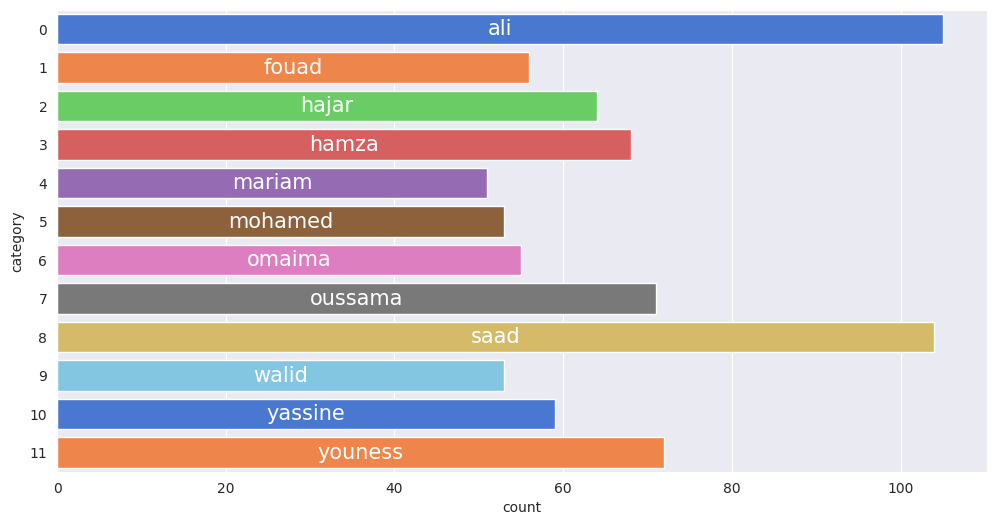

In [9]:
plt.figure(figsize=(12,6))
splot = sns.countplot(data = data.sort_values(by='category'), y ='category',palette='muted', saturation=1)
plt.bar_label(container=splot.containers[0],labels=category, label_type='center', size=15, color='w')
plt.show()

/content/drive/MyDrive/palmar/data_more_50/walid/Hand_0003925.jpg


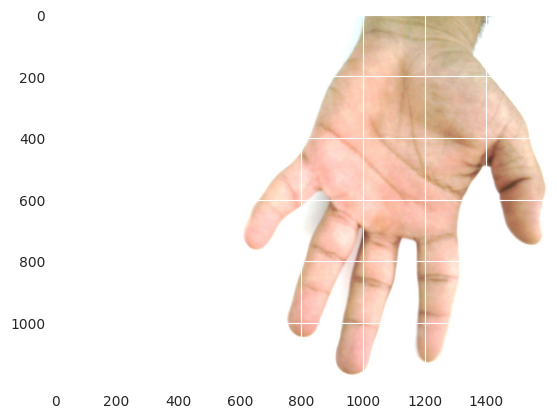

In [10]:
sample = random.choice(data['file_name'])
image = load_img(sample)
print(sample)
plt.imshow(image)
plt.show()

# **Image crop**

In [11]:
def crop_hand_image(image_path, cropped_images_list, error_images_list ):
    # Load and preprocess the image
    hand_image = cv2.imread(image_path)
    # Convert image to RGB format
    hand_image_rgb = cv2.cvtColor(hand_image, cv2.COLOR_BGR2RGB)

    # Initialize Hand Tracking module
    mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

    # Process hand image
    results = mp_hands.process(hand_image_rgb)

    # Check if hand was detected
    if results.multi_hand_landmarks:
        # Extract hand landmarks and perform palm extraction
        for hand_landmarks in results.multi_hand_landmarks:
            # Extract palm center
            palm_center_x = int(hand_landmarks.landmark[mp.solutions.hands.HandLandmark.WRIST].x * hand_image.shape[1])
            palm_center_y = int(hand_landmarks.landmark[mp.solutions.hands.HandLandmark.WRIST].y * hand_image.shape[0])

            # Define the size of the cropped area around the palm center
            crop_size_vertical = 510
            crop_size_horizontal = 320  # Adjust this value to reduce the horizontal size

            # Calculate the coordinates for cropping
            x1 = max(0, palm_center_x - crop_size_horizontal)
            y1 = max(0, palm_center_y - crop_size_vertical)
            x2 = min(hand_image.shape[1], palm_center_x + crop_size_horizontal)
            y2 = min(hand_image.shape[0], palm_center_y + crop_size_vertical)

            # Crop the image
            cropped_image = hand_image[y1:y2, x1:x2]
            cropped_images_list.append(cropped_image)
    else:
      error_images_list.append(image_path)
    # Release resources
    mp_hands.close()

In [12]:
# Iterate over the rows of the dataframe
cropped_images_list = []
error_images_list = []
for index, row in data.iterrows():
    image_path = row['file_name']
    category = row['category']
    crop_hand_image(image_path, cropped_images_list, error_images_list)

In [13]:
def delete_images(image_paths):
    for path in image_paths:
        if os.path.exists(path):
            os.remove(path)
            print(f"Deleted image: {path}")
        else:
            print(f"Image not found: {path}")

delete_images(error_images_list)

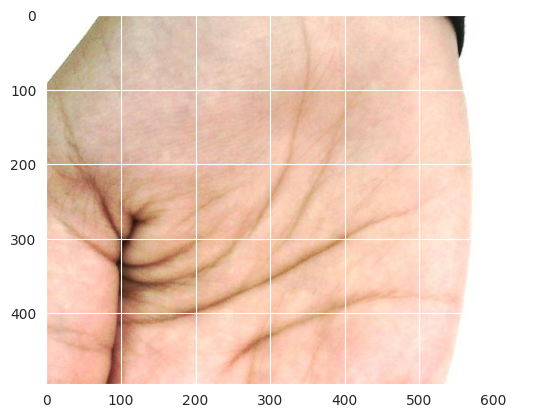

In [14]:
# Select a random cropped image
random_cropped_image = random.choice(cropped_images_list)
# Display the cropped image
image = cv2.cvtColor(random_cropped_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# **Image segmentation**

In [15]:
def segment_hand_skin_color(hand_image):
    # Load and preprocess the image
    #image = cv2.imread(image_path)
    image_hsv = cv2.cvtColor(hand_image, cv2.COLOR_BGR2HSV)

    # Define the skin color range in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Create a binary mask by thresholding the HSV image
    skin_mask = cv2.inRange(image_hsv, lower_skin, upper_skin)

    # Perform morphological operations for noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Perform dilation to fill gaps in the segmented hand
    skin_mask = cv2.dilate(skin_mask, kernel, iterations=9)

    # Perform erosion to further refine the segmented hand
    skin_mask = cv2.erode(skin_mask, kernel, iterations=8)

    # Apply the segmentation mask to the original image
    segmented_image = cv2.bitwise_and(hand_image, hand_image, mask=skin_mask)

    # Resize the segmented image to 1024x1024
    #segmented_image = cv2.resize(segmented_image, (1024, 1024))

    return segmented_image

In [16]:
segmented_images = []
for image in cropped_images_list:
    segmented_image = segment_hand_skin_color(image)
    # Append segmented image to the list
    segmented_images.append(segmented_image)

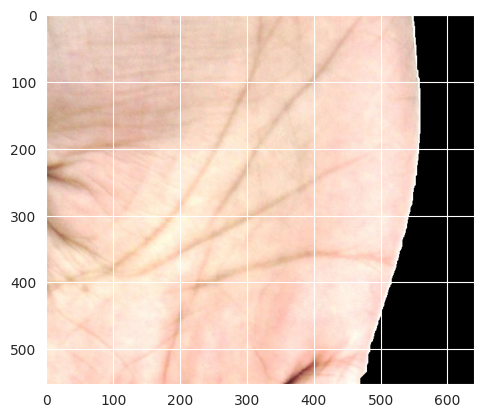

In [17]:
# Select a random segmented image
random_segmented_image = random.choice(segmented_images)

# Display the segmented image
image = cv2.cvtColor(random_segmented_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# **Image enhancement**

In [21]:
def enhance_image_for_palm(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Apply noise reduction with median filter
    denoised = cv2.medianBlur(equalized, 3)

    # Apply adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(10, 10))
    enhanced = clahe.apply(denoised)
    enhanced = np.array(enhanced)

    return enhanced

In [22]:
# List to store enhanced images
enhanced_images = []
for image in segmented_images:
    enhanced_image = enhance_image_for_palm(image)
    enhanced_images.append(enhanced_image)

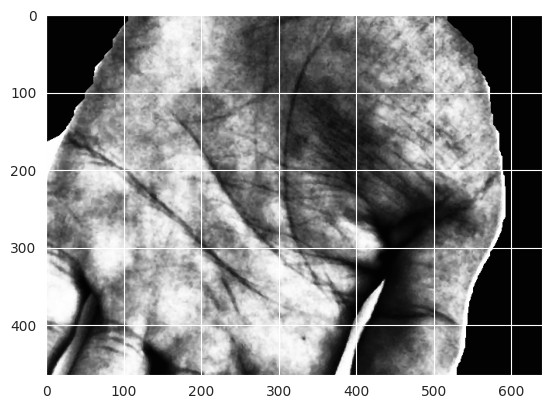

In [23]:
# Select a random segmented image
random_enhanced_image = random.choice(enhanced_images)

# Display the segmented image
image = cv2.cvtColor(random_enhanced_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# nomalisation

In [24]:
len(enhanced_images)

811

In [25]:
len(data['category'])

811

In [26]:
def normalize_images(images):
    normalized_images = []
    for image in images:
        # Resize image to 512x512
        resized_image = cv2.resize(image, (512, 512))
        normalized_images.append(resized_image)
    return normalized_images

# Example usage
normalized_images = normalize_images(cropped_images_list)


# **Spliting data**

In [27]:
labels = data['category']

# Split the image list and labels into train and test/valid sets
image_train, image_test_valid, label_train, label_test_valid = train_test_split(normalized_images, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

# Further split the test/valid set into separate test and validation sets
#image_test, image_valid, label_test, label_valid = train_test_split(image_test_valid, label_test_valid, test_size=0.5, random_state=42, shuffle=True, stratify=label_test_valid)


In [28]:
label_train = label_train.tolist()
label_test = label_test.tolist()
label_valid = label_valid.tolist()

In [29]:
image_train[0].shape

(512, 512, 3)

In [44]:
image_train_rgb = np.array(image_train)
image_test_rgb = np.array(image_test_valid)
label_train = np.array(label_train)
label_test = np.array(label_test_valid)
#image_valid_rgb = np.array(image_valid)
#label_valid = np.array(label_valid)

In [45]:
image_train_rgb.shape

(567, 512, 512, 3)

In [46]:
label_train.shape

(567,)

In [47]:
label_train_one_hot = to_categorical(label_train, num_classes=12)
label_valid_one_hot = to_categorical(label_valid, num_classes=12)

In [48]:
label_test_one_hot = to_categorical(label_test, num_classes=12)

# **Free ressources**

In [35]:
del cropped_images_list
del normalized_images

In [36]:
import gc

gc.collect()

3299

# **Model training**

In [90]:
baseModel = ResNet50(input_shape=(512,512,3), include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(24, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(12, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [91]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [92]:
opt = Adam(learning_rate=0.0004)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss',
                               mode='min',
                               patience=15,
                               verbose=1,
                               min_delta=0.0001,
                               restore_best_weights=True)

In [94]:
# Fit the model
history = model.fit(
    image_train_rgb,
    label_train_one_hot,
    batch_size=24,
    epochs=100,
    callbacks=[early_stopping]
    #validation_data=(image_valid_rgb, label_valid_one_hot)
)

Epoch 1/100
24/24 [==============================] - 11s 338ms/step - loss: 2.1558 - accuracy: 0.4004
Epoch 2/100
24/24 [==============================] - 8s 341ms/step - loss: 1.1696 - accuracy: 0.5379
Epoch 3/100
24/24 [==============================] - 8s 349ms/step - loss: 1.0578 - accuracy: 0.5485
Epoch 4/100
24/24 [==============================] - 8s 354ms/step - loss: 1.0105 - accuracy: 0.5891
Epoch 5/100
24/24 [==============================] - 8s 346ms/step - loss: 0.8300 - accuracy: 0.6772
Epoch 6/100
24/24 [==============================] - 8s 339ms/step - loss: 0.7563 - accuracy: 0.7037
Epoch 7/100
24/24 [==============================] - 8s 337ms/step - loss: 0.7498 - accuracy: 0.7143
Epoch 8/100
24/24 [==============================] - 8s 332ms/step - loss: 0.6737 - accuracy: 0.7672
Epoch 9/100
24/24 [==============================] - 8s 334ms/step - loss: 0.5316 - accuracy: 0.8642
Epoch 10/100
24/24 [==============================] - 8s 328ms/step - loss: 0.5963 - accur

In [95]:
test_loss, test_accuracy = model.evaluate(image_test_rgb, label_test_one_hot)

8/8 [==============================] - 35s 402ms/step - loss: 0.0389 - accuracy: 0.9959


In [96]:
predictions = model.predict(image_test_rgb)

8/8 [==============================] - 4s 428ms/step


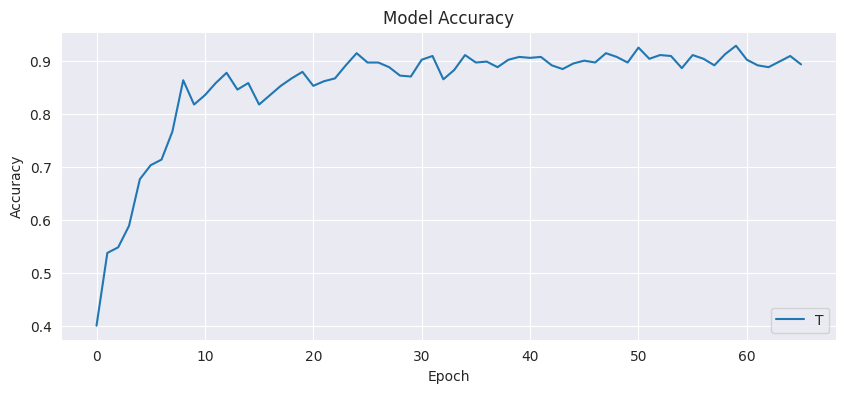

In [97]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend('Train', loc='lower right')
plt.show()

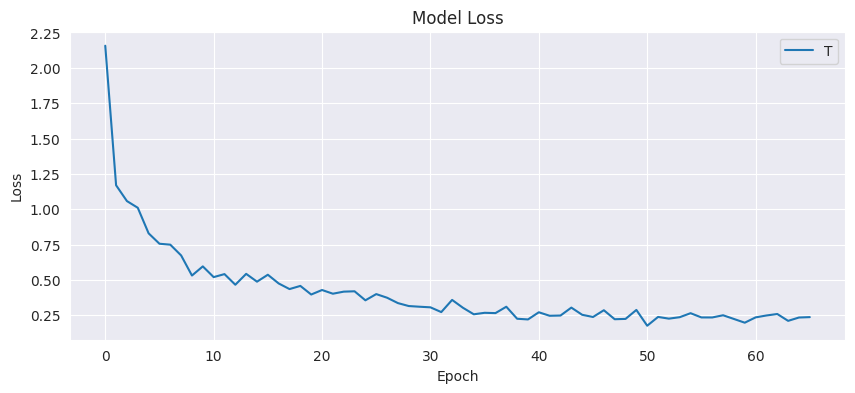

In [98]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend('Train', loc='upper right')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/palmar/trained_model_resnet50.h5')